<a href="https://colab.research.google.com/github/jgbrasier/protein-classification/blob/main/ProtClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep sequence models for protein classification

In [82]:
import io
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import datetime
from collections import Counter
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader

## Downloading data
download and save to local drive: https://www.kaggle.com/shahir/protein-data-set

### Uploading data to Colab

Click on "chose files" upload both:
 - pdb_data_seq.csv
 - pdb_data_no_dups.csv

In [49]:
from google.colab import files
# upload 'pdb_data_seq.csv'
uploaded = files.upload()

Saving pdb_data_seq.csv to pdb_data_seq.csv


In [50]:
# upload 'pdb_data_np_dupes.csv'
uploaded2 = files.upload()

Saving pdb_data_no_dups.csv to pdb_data_no_dups.csv


In [51]:
# convert data to pandas dataframe
seq = pd.read_csv(io.BytesIO(uploaded['pdb_data_seq.csv']))
nodups = pd.read_csv(io.BytesIO(uploaded2['pdb_data_no_dups.csv']))

## Data cleaning and preparation

### Data analysis

In [52]:
# merge both data frames on structure id, remove duplicates
df = nodups.merge(seq, how='inner', on='structureId').drop_duplicates(['structureId'])
# remove NaN values
df = df.dropna()
# keep only proteins and reset indexes
df = df[df['macromoleculeType_x'] == 'Protein'].reset_index()
# keep structureId, classification, residueCount_x, sequence
df = df[['structureId', 'classification', 'residueCount_x', 'sequence']]
df.columns = ['structureId', 'classification', 'residueCount', 'sequence']
print("Total number of unique proteins:", len(df))

Total number of unique proteins: 60757


In [20]:
df.head()

,structureId,classification,residueCount,sequence
0,1914,ALU DOMAIN,232,MASMTGGQQMGRIPGNSPRMVLLESEQFLTELTRLFQKCRSSGSVF...
1,1A04,SIGNAL TRANSDUCTION PROTEIN,430,SNQEPATILLIDDHPMLRTGVKQLISMAPDITVVGEASNGEQGIEL...
2,1A0R,COMPLEX (TRANSDUCER/TRANSDUCTION),650,XSELDQLRQEAEQLKNQIRDARKACADATLSQITNNIDPVGRIQMR...
3,1A2B,ONCOGENE PROTEIN,182,SMAAIRKKLVIVGDVACGKTCLLIVFSKDQFPEVYVPTVFENYVAD...
4,1A2X,COMPLEX (SKELETAL MUSCLE/MUSCLE PROTEIN),206,TDQQAEARSYLSEEMIAEFKAAFDMFDADGGGDISVKELGTVMRML...


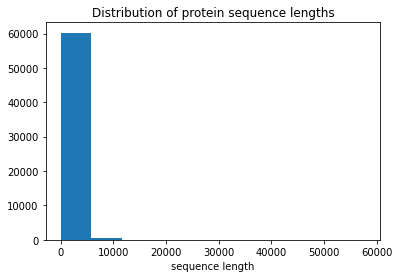

In [21]:
plt.hist(df['residueCount'])
plt.xlabel('sequence length')
plt.title('Distribution of protein sequence lengths')
plt.show()

In [53]:
# remove proteins with lengths > 2000 to save compute time on LSTM models
max_len = 2000
df = df[df['residueCount'] < max_len]
print("Total number of unique proteins:", len(df))
print("Total number of unique classification labels:", len(df.classification.unique()))

Total number of unique proteins: 57359
Total number of unique classification labels: 2052


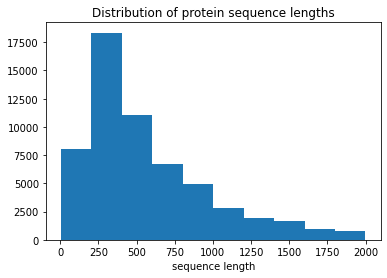

In [23]:
plt.hist(df['residueCount'])
plt.xlabel('sequence length')
plt.title('Distribution of protein sequence lengths')
plt.show()

In [55]:
# keep only 15 most important classes by instance count
N_class = 10
count = Counter(df.classification)
sort = count.most_common()[:N_class]
classes = np.array(sort)[:, 0]
df = df[[c in classes for c in df.classification]]
sequences = df.sequence.values
print("Total number of unique proteins:", len(df))

Total number of unique proteins: 34288
['HYDROLASE' 'TRANSFERASE' 'OXIDOREDUCTASE' 'IMMUNE SYSTEM' 'LYASE'
 'TRANSCRIPTION' 'TRANSPORT PROTEIN' 'HYDROLASE/HYDROLASE INHIBITOR'
 'SIGNALING PROTEIN' 'TRANSFERASE/TRANSFERASE INHIBITOR']


In [27]:
df.classification.value_counts()

HYDROLASE                            9704
TRANSFERASE                          7277
OXIDOREDUCTASE                       5544
IMMUNE SYSTEM                        2333
LYASE                                2177
TRANSCRIPTION                        1660
TRANSPORT PROTEIN                    1608
HYDROLASE/HYDROLASE INHIBITOR        1457
SIGNALING PROTEIN                    1286
TRANSFERASE/TRANSFERASE INHIBITOR    1242
Name: classification, dtype: int64

In [28]:
# one hot encode classes
lb = LabelBinarizer()
Y = lb.fit_transform(df.classification)

# tokenize our sequences
# create fit
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
#represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(sequences)
X = sequence.pad_sequences(X, maxlen=max_len)
print('X shape:', X.shape, 'Y shape:', Y.shape)

X shape: (34288, 2000) Y shape: (34288, 10)


In [41]:
# train/test split
train_data, test_data, train_labels, test_labels = train_test_split(X, Y, test_size=.1)
train_data = th.from_numpy(train_data)
test_data = th.from_numpy(test_data)
train_labels = th.from_numpy(train_labels)
test_labels = th.from_numpy(test_labels)


### Save/Load PyTorch tensors
prevents from loading whole dataset which takes time


In [56]:
# to save/load model on your google drive, you need to mount it first
# follow instructions.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# save
work_dir = f'/content/gdrive/My Drive/Colab Notebooks/Data'
th.save(train_data, os.path.join(work_dir, 'train_data.pt'))
th.save(test_data, os.path.join(work_dir, 'test_data.pt'))
th.save(train_labels, os.path.join(work_dir, 'train_labels.pt'))
th.save(test_labels, os.path.join(work_dir, 'test_labels.pt'))


In [58]:
df.to_csv(os.path.join(work_dir, 'df.csv') )

In [41]:
work_dir = f'/content/gdrive/My Drive/Colab Notebooks/Data'
train_data = th.load(os.path.join(work_dir, 'train_data.pt'))
test_data = th.load(os.path.join(work_dir, 'test_data.pt'))
train_labels = th.load(os.path.join(work_dir,'train_labels.pt'))
test_labels = th.load(os.path.join(work_dir, 'test_labels.pt'))
assert len(train_data) == len(train_labels)
assert len(test_data) == len(test_labels)
print('Training size: ', train_data.size())
print('Testing size: ', test_data.size())

Training size:  torch.Size([30859, 2000])
Testing size:  torch.Size([3429, 2000])


GPU compute setup

In [4]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
th.cuda.get_device_name()


'Tesla P100-PCIE-16GB'

## Model

In [43]:
# Hyperparameters
vocab_size = len(th.unique(train_data)) # number of unique amino acids
sequence_length = 2000 # maximum length of sequence
embedding_size = 11 # 
hidden_size = 512
num_classes = 10 # number of different proteins
lr = 0.001
batch_size = 64
n_epochs = 20

# BiLSTM Params
num_layers = 1 # number of layers for BiLTSM model

# CNN Params
n_filters = 100
filter_sizes = [3, 10]


In [42]:
class Dataset(th.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, y):
        'Initialization'
        self.X = X
        self.y = y
        self.list_IDs = [i for i in range(len(X))]

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        # Load data and get label
        X = self.X[ID]
        y = self.y[ID]
        return X, y

### BiLSTM

In [22]:
class BiLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_size, hidden_size, num_layers, num_classes, batch_size):
    """
    vocab_size: int, number of words in vocbulary
    emedding_size: int, embedding dimension
    hidden_size: int, size of hidden layer
    num_layers: int, number of LSTM layers
    num_classes: number of classes
    batch_size: size of mini batches
    """
    super(BiLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.batch_size = batch_size
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    # self.hidden = self.init_hidden()
    self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
    self.dropout = nn.Dropout(0.3)
    self.fc1 = nn.Linear(hidden_size*2, 128)
    self.fc2 = nn.Linear(128, num_classes)
  
  def init_hidden(self):
    # initialise hidden & cell state
    h0 = Variable(th.zeros(self.num_layers*2, self.batch_size, self.hidden_size)).to(device)
    c0 = Variable(th.zeros(self.num_layers*2, self.batch_size, self.hidden_size)).to(device)
    return (h0, c0)

  def forward(self, inputs, hidden):
    x = self.embedding(inputs) # x=[batch_size, sequence_len, embedding_size]
    # lstm_out, self.hidden = self.lstm(x, self.hidden) # lstm_out=[batch_size, sequence_len, hidden_size]
    lstm_out, hidden = self.lstm(x, hidden)
    lstm_out = lstm_out.permute(1,0,2) # lstm_out=[sequence_len, batch_size, hidden_size]
    y = self.fc1(lstm_out[-1]) # take last hidden state, y=[batch_size, num_classes]
    y = F.leaky_relu(y, 0.1)
    y = self.dropout(y)
    y = self.fc2(y)
    probs = F.log_softmax(y, dim=1) # probs=[batch_size, num_classes]
    return probs

# generate model instance
bilstm_model = BiLSTM(vocab_size, embedding_size, hidden_size, num_layers, num_classes, batch_size).to(device)
print(bilstm_model)

BiLSTM(
  (embedding): Embedding(26, 8)
  (lstm): LSTM(8, 1024, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### CNN

In [ ]:
class CNN(nn.Module):
  """
  vocab_size: int, number of words in vocbulary
  emedding_size: int, embedding dimension
  hidden_size: int, size of hidden layer
  n_filters: int, number of filters to use per conv layer
  filter_sizes: list(int), list of conv filter sizes
  batch_size: size of mini batches
  """
  def __init__(self, vocab_size, embedding_size, hidden_size, n_filters, filter_sizes, num_classes):
    super(CNN, self).__init__()        
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.convs = nn.ModuleList([nn.Conv2d(in_channels=1,
                                          out_channels=n_filters,
                                          kernel_size=(fs, embedding_size)) for fs in filter_sizes])
    self.dropout = nn.Dropout(0.5)
    self.fc1 = nn.Linear(len(filter_sizes)*n_filters, hidden_size, bias=True)  
    self.fc2 = nn.Linear(hidden_size, num_classes, bias=True)

  def forward(self, inputs):
    x = self.embedding(inputs) # x=[batch_size, seq_len, embedding_size]
    x = x.unsqueeze(1) # x=[batch_size, 1, seq_len, embedding_size]  
    conv_out = [F.relu(conv(x)).squeeze(3) for conv in self.convs] # conv_n = [batch size, n_filters, seq_len - filter_sizes[n]]
    pool_out = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conv_out] # pool_n = [batch size, n_filters]
    cat = self.dropout(th.cat(pool_out, dim = 1)) # cat = [batch size, len(filter_sizes)*n_filters]
    y = self.fc1(F.relu(cat))
    y = self.dropout(y)
    y = self.fc2(y)
    probs = F.log_softmax(y, dim=1) # probs=[batch_size, num_classes]
    return probs

cnn_model = CNN(vocab_size, embedding_size, hidden_size, n_filters, filter_sizes, num_classes).to(device)
print(cnn_model)

CNN(
  (embedding): Embedding(26, 8)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 8), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(5, 8), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(7, 8), stride=(1, 1))
    (3): Conv2d(1, 100, kernel_size=(9, 8), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=400, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=15, bias=True)
)


### CNN BiLSTM

In [44]:
class CNN_BiLSTM(nn.Module):
  def __init__(self, vocab_size, embedding_size, hidden_size, n_filters, filter_sizes, num_layers, num_classes, batch_size):
    """
    vocab_size: int, number of words in vocbulary
    emedding_size: int, embedding dimension
    hidden_size: int, size of hidden layer
    num_layers: int, number of LSTM layers
    num_classes: number of classes
    batch_size: size of mini batches
    """
    super(CNN_BiLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.batch_size = batch_size
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.convs = nn.ModuleList([nn.Conv2d(in_channels=1,
                                          out_channels=n_filters,
                                          kernel_size=(fs, embedding_size)) for fs in filter_sizes])
    self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
    self.dropout = nn.Dropout(0.3)
    l = n_filters*len(filter_sizes) + hidden_size*2
    self.fc1 = nn.Linear(l, l//2)
    self.fc2 = nn.Linear(l//2, num_classes)
  
  def init_hidden(self):
    # initialise hidden & cell state
    h0 = Variable(th.zeros(self.num_layers*2, self.batch_size, self.hidden_size)).to(device)
    c0 = Variable(th.zeros(self.num_layers*2, self.batch_size, self.hidden_size)).to(device)
    return (h0, c0)

  def forward(self, inputs, hidden):
    x = self.embedding(inputs) # x=[batch_size, seq_len, embedding_size]

    cnn_x = x.unsqueeze(1) # x=[batch_size, 1, seq_len, embedding_size]  
    cnn_x = [F.relu(conv(cnn_x)).squeeze(3) for conv in self.convs] # conv_n = [batch size, n_filters, seq_len - filter_sizes[n]]
    cnn_x = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in cnn_x]
    cnn_out = self.dropout(th.cat(cnn_x, dim = 1))

    lstm_out, hidden = self.lstm(x, hidden)
    lstm_out = lstm_out.permute(1,0,2) # lstm_out=[sequence_len, batch_size, hidden_size] because batch_first = True
    # feature extraction 1 using maxpool1d over all states
    # lstm_out = th.transpose(lstm_out, 0, 1)
    # lstm_out = th.transpose(lstm_out, 1, 2)
    # lstm_out = F.max_pool1d(lstm_out, lstm_out.size(2)).squeeze(2)
    # feature extraction 2 taking last hidden state
    lstm_out = lstm_out[-1]
    lstm_out = F.relu(lstm_out)

    cnn_out = th.transpose(cnn_out, 0, 1)
    lstm_out = th.transpose(lstm_out, 0, 1)
    cnn_lstm_out = th.cat((cnn_out, lstm_out), 0)
    cnn_lstm_out = th.transpose(cnn_lstm_out, 0, 1)

    y = F.relu(cnn_lstm_out)
    y = self.fc1(y)
    y = self.dropout(y)
    y = F.relu(y)
    y = self.fc2(y)
    probs = F.log_softmax(y, dim=1) # probs=[batch_size, num_classes]
    return probs

# generate model instance
# cnnbilstm_model = CNN_BiLSTM(vocab_size, embedding_size, hidden_size, n_filters, filter_sizes, num_layers, num_classes, batch_size).to(device)
# print(cnnbilstm_model)

## Training

#### Utils

In [25]:

# visualize tensor dimensions after each layer
batch, label = list(train_generator)[0]
label = th.argmax(label, 1).to(device)
batch = batch.to(device)

# initialise layers
emb = nn.Embedding(vocab_size, embedding_size).to(device)
convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, embedding_size)) for fs in filter_sizes]).to(device)
lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True, bidirectional=True).to(device)
lin = nn.Linear(hidden_size*2, num_classes).to(device)

# init hidden/cell state
h0 = Variable(th.zeros(num_layers*2, batch_size, hidden_size)).to(device)
c0 = Variable(th.zeros(num_layers*2, batch_size, hidden_size)).to(device)

x = emb(batch)
print('emb_out:', x.size())
cnn_x = x.unsqueeze(1)
print('cnn_emb_out:', cnn_x.size())

# CNN
cnn_out = [F.relu(conv(cnn_x)).squeeze(3) for conv in convs]
cnn_out = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in cnn_out]
cnn_out = th.cat(cnn_out, dim = 1)
print('cnn_out:', cnn_out.size())
cnn_out = th.transpose(cnn_out, 0, 1)
print('cnn_permute_out:', cnn_out.size())

# LSTM

lstm_out, _ = lstm(lstm_x, (h0, c0))
print('lstm_out:', lstm_out.size())
lstm_out = lstm_out.permute(1,0,2) # lstm_out=[sequence_len, batch_size, hidden_size]
print('lstm_out (permute):', lstm_out.size())
# lstm_out = th.transpose(lstm_out, 0, 1)
# lstm_out = th.transpose(lstm_out, 1, 2)
# lstm_out = F.max_pool1d(lstm_out, lstm_out.size(2)).squeeze(2)
lstm_out = lstm_out[-1]
lstm_out = th.transpose(lstm_out, 0, 1)
print('lstm_permute_out:', lstm_out.size())


cnn_lstm_out = th.cat((cnn_out, lstm_out), 0)
print('cnn_lstm_out:', cnn_lstm_out.size())

# lin_out = lin(lstm_out)
# print('lin_out:', lin_out.size())
# y = F.log_softmax(lin_out, dim=1)
# print('activation_out:', y.size())

emb_out: torch.Size([16, 2000, 8])
cnn_emb_out: torch.Size([16, 1, 2000, 8])
cnn_out: torch.Size([16, 200])
cnn_permute_out: torch.Size([200, 16])
lstm_out: torch.Size([16, 2000, 1024])
lstm_out (permute): torch.Size([2000, 16, 1024])
lstm_permute_out: torch.Size([1024, 16])
cnn_lstm_out: torch.Size([1224, 16])


#### Training Utils

In [46]:
# Batch training loop
def train(dataloader, model, optimizer, criterion, pred_func):
  """
  Main function for training LSTM model and printing prompt
  """
  model.train()
  total_acc, total_count = 0, 0
  log_interval = 100
  start_time = time.time()

  for idx, (batch, label) in enumerate(dataloader):
    batch, label = batch.to(device), label.to(device)
    model.zero_grad()
    model, pred = pred_func(model, batch)
    label = th.argmax(label, 1) # one_hot --> indexing
    loss = criterion(pred, label)
    loss.backward()
    th.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
    optimizer.step()
    total_acc += (pred.argmax(1) == label).sum().item()
    total_count += label.size(0)
    if idx % log_interval == 0 and idx > 0:
        elapsed = time.time() - start_time
        print('| epoch {:3d} | {:5d}/{:5d} batches '
              '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader), total_acc/total_count))
        total_acc, total_count = 0, 0
        start_time = time.time()

# batch evaluation loop 
def evaluate(dataloader, model, criterion, pred_func):
  """
  Main function for evaluating LSTM model & printing prompt
  """
  model.eval()
  total_acc, total_count = 0, 0
  metrics = {'acc': float(), 'loss': float()}

  with th.no_grad():
    for idx, (batch, label) in enumerate(dataloader):
      batch, label = batch.to(device), label.to(device)
      model, pred = pred_func(model, batch)
      label = th.argmax(label, 1) # one_hot --> indexing
      loss = criterion(pred, label)
      total_acc += (pred.argmax(1) == label).sum().item()
      total_count += label.size(0)
  metrics['acc'] = total_acc/total_count
  metrics['loss'] = loss.item()
  return metrics

def append_metrics(history, metrics):
  """ append metrics dictionary to history dictionary """
  for key in metrics.keys():
    history[key].append(metrics[key])
  return history

def LSTM_pred(model, batch):
  """ LSTM initialisation and prediction for training loop """
  hidden = model.init_hidden() # initalise hidden states
  pred = model(batch, hidden)
  return model, pred

def CNN_pred(model, batch):
  """ CNN prediction for taining loop """
  pred = model(batch)
  return model, pred

In [47]:
# Train/Val/Test generators
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=.1)
X_test, y_test = test_data, test_labels
train_set = Dataset(X_train, y_train)
train_generator = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_set = Dataset(X_val, y_val)
val_generator = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_set = Dataset(X_test, y_test)
test_generator = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True)
print('Nb training examples:', len(X_train))
print('Nb validation examples:', len(X_val))
print('Nb test examples:', len(X_test))
# X_train, X_val, X_test, y_train, y_val, y_test =  X_train.to(device), X_val.to(device), X_test.to(device), y_train.to(device), y_val.to(device), y_test.to(device)
print('Is CUDA? Train: {}, Val: {}, Test: {}'.format(X_train.is_cuda, X_val.is_cuda, X_test.is_cuda))

Nb training examples: 27773
Nb validation examples: 3086
Nb test examples: 3429
Is CUDA? Train: False, Val: False, Test: False


In [11]:
# save weigths to new directory for each training
save_dir = f'/content/gdrive/My Drive/Colab Notebooks/Weights'
date = datetime.now().strftime("%Y%m%d-%I%M_%p")
new_dir = os.path.join(save_dir, 'training_'+ date)
os.makedirs(new_dir)

total_accu=None
train_hist = {'acc': [], 'loss': []}
val_hist = {'acc': [], 'loss': []}

# input model and prediction function for training
# model = CNN(vocab_size, embedding_size, hidden_size, n_filters, filter_sizes, num_classes).to(device)
# model = BiLSTM(vocab_size, embedding_size, hidden_size, num_layers, num_classes, batch_size).to(device)
model = CNN_BiLSTM(vocab_size, embedding_size, hidden_size, n_filters, filter_sizes, num_layers, num_classes, batch_size).to(device)
pred_func = LSTM_pred
name = model.__class__.__name__ # model name

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1., gamma=0.1)

for epoch in range(1, n_epochs+ 1):
  epoch_start_time = time.time()
  # train
  train(train_generator, model, optimizer, criterion, pred_func)
  # evaluate
  train_metrics = evaluate(train_generator, model, criterion, pred_func)
  val_metrics = evaluate(val_generator, model, criterion, pred_func)
  # log history
  train_hist = append_metrics(train_hist, train_metrics)
  val_hist = append_metrics(val_hist, val_metrics)
  # save model
  th.save({'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()},
            os.path.join(new_dir, name +'_'+ str(epoch) +'.pt'))
  # update accuracy for each epoch
  if total_accu is not None and total_accu > val_metrics['acc']:
    scheduler.step()
  else:
    total_accu = val_metrics['acc']
  print('-' * 59)
  print('| end of epoch {:3d} | time: {:5.2f}s | '
        'val accuracy {:8.3f} '.format(epoch,time.time()-epoch_start_time,val_metrics['acc']))
  print('-' * 59)

| epoch   1 |   100/  433 batches | accuracy    0.269
| epoch   1 |   200/  433 batches | accuracy    0.311
| epoch   1 |   300/  433 batches | accuracy    0.357
| epoch   1 |   400/  433 batches | accuracy    0.381
-----------------------------------------------------------
| end of epoch   1 | time: 274.83s | val accuracy    0.407 
-----------------------------------------------------------
| epoch   2 |   100/  433 batches | accuracy    0.414
| epoch   2 |   200/  433 batches | accuracy    0.435
| epoch   2 |   300/  433 batches | accuracy    0.466
| epoch   2 |   400/  433 batches | accuracy    0.481
-----------------------------------------------------------
| end of epoch   2 | time: 274.48s | val accuracy    0.557 
-----------------------------------------------------------
| epoch   3 |   100/  433 batches | accuracy    0.536
| epoch   3 |   200/  433 batches | accuracy    0.549
| epoch   3 |   300/  433 batches | accuracy    0.563
| epoch   3 |   400/  433 batches | accuracy  

In [12]:
def plot_metrics(train_hist, val_hist, nb_epochs):
  """ plot metrics using model history dictionary """
  x = range(1, nb_epochs+1)
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
  fig.tight_layout(pad=3)
  ax1.plot(x, train_hist['acc'], color='blue', label='train')
  ax1.plot(x, val_hist['acc'], color='orange', label='val')
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('accuracy %')
  ax1.legend()
  ax2.plot(x, train_hist['loss'], color='blue', label='train')
  ax2.plot(x, val_hist['loss'], color='orange', label='val')
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('loss')
  ax2.legend()

  plt.show()


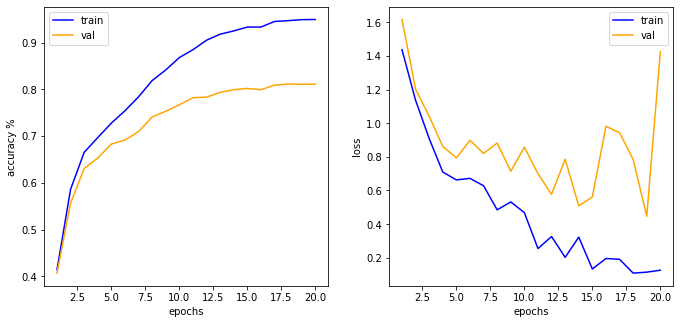

CNN_BiLSTM(
  (embedding): Embedding(26, 11)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 11), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(10, 11), stride=(1, 1))
  )
  (lstm): LSTM(11, 512, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=1224, out_features=612, bias=True)
  (fc2): Linear(in_features=612, out_features=10, bias=True)
)


In [14]:
plot_metrics(train_hist, val_hist, n_epochs)
print(model)

## Eval

In [74]:
# load best model and test it
weights_dir = os.path.join(save_dir, 'training_CNN_BiLSTM_2')
checkpoint = th.load(os.path.join(weights_dir, 'CNN_BiLSTM_19.pt'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

test_metrics = evaluate(test_generator, model, criterion, pred_func)
print(test_metrics)

{'acc': 0.8142688679245284, 'loss': 1.616955041885376}


In [90]:
# analyse detection percentage

df = pd.read_csv(os.path.join(work_dir, 'df.csv'))
count = Counter(df.classification)
sort = count.most_common()[:N_class]
classes = np.array(sort)[:, 0]

class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))

y_true = []
y_pred = []

with th.no_grad():
  for idx, (batch, labels) in enumerate(test_generator):
    batch, labels = batch.to(device), labels.to(device)
    model, pred = pred_func(model, batch)
    labels = th.argmax(labels, 1) # one_hot --> indexing
    _, predicted = th.max(pred, 1)
    y_true = np.concatenate((y_true, labels.cpu().numpy()))
    y_pred = np.concatenate((y_pred, predicted.cpu().numpy()))
    c = (predicted == labels).squeeze()
    for i in range(len(labels)):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1

for i in range(num_classes):
  print('{} acc: {:.2f}%'.format(classes[i], 100 * class_correct[i] / class_total[i]))

HYDROLASE acc: 85.93%
TRANSFERASE acc: 53.96%
OXIDOREDUCTASE acc: 91.30%
IMMUNE SYSTEM acc: 79.00%
LYASE acc: 91.03%
TRANSCRIPTION acc: 57.02%
TRANSPORT PROTEIN acc: 82.86%
HYDROLASE/HYDROLASE INHIBITOR acc: 82.21%
SIGNALING PROTEIN acc: 45.38%
TRANSFERASE/TRANSFERASE INHIBITOR acc: 75.82%


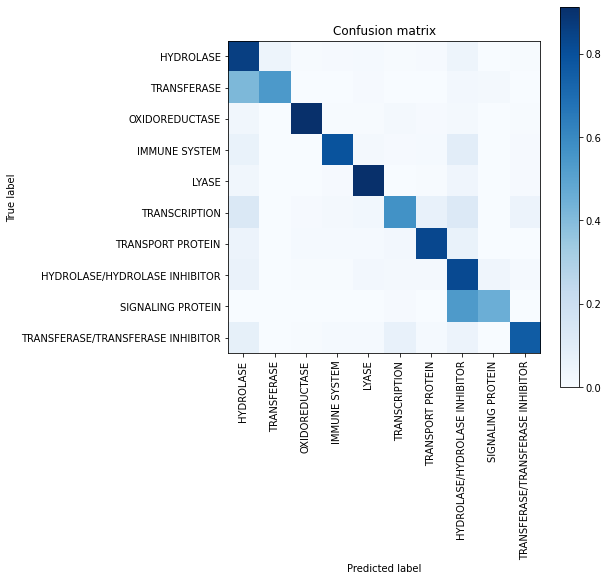

                                   precision    recall  f1-score   support

                        HYDROLASE       0.83      0.86      0.85       995
                      TRANSFERASE       0.63      0.54      0.58       139
                   OXIDOREDUCTASE       0.93      0.91      0.92       207
                    IMMUNE SYSTEM       0.88      0.79      0.83       219
                            LYASE       0.92      0.91      0.91       546
                    TRANSCRIPTION       0.61      0.57      0.59       114
                TRANSPORT PROTEIN       0.79      0.83      0.81       175
    HYDROLASE/HYDROLASE INHIBITOR       0.75      0.82      0.79       714
                SIGNALING PROTEIN       0.67      0.45      0.54       130
TRANSFERASE/TRANSFERASE INHIBITOR       0.80      0.76      0.78       153

                         accuracy                           0.81      3392
                        macro avg       0.78      0.74      0.76      3392
                     we

In [97]:
cm = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=classes)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(7,7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(class_report)